# Tutorial2: PyTorch basics

## Outline

- Datasets
- Models
- Losses
- Optimizers

Official resources:
* [Deep Learning with PyTorch: a 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [PyTorch documentation](https://pytorch.org/docs/stable/index.html)

Here no details, mostly visualization, with linear regression.

### Imports

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
plt.rcParams.update({'font.size': 16})

In [2]:
x = torch.rand(20, 5)
x
((x.norm(dim=1) - 1).abs() < 1e-10).float()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Datasets

### A raw dataset

The data are obtained from the model 
$$
x \mapsto y:=Ax + b
$$
with $x\in\mathbb R^{input\_dim}$ and $y\in\mathbb R^{output\_dim}$.

In [3]:
input_dim = 1
output_dim = 1

A = 2 * np.random.rand(output_dim, input_dim) - 1
b = 2 * np.random.rand(output_dim) - 1

true_model = lambda x: A @ x + b

We get a training set by randomly sampling and noisy observations
\begin{align*}
&x_i \sim U([-1, 1])\\
&y_i = A x_i + b + \nu_i
\end{align*}

In [4]:
n_train = 1000
noise_level = 0.04

# Generate a random set of n_train samples
X_train = np.random.rand(n_train, input_dim)
y_train = np.array([true_model(x) for x in X_train])

# Add some noise
y_train += noise_level * np.random.standard_normal(size=y_train.shape)

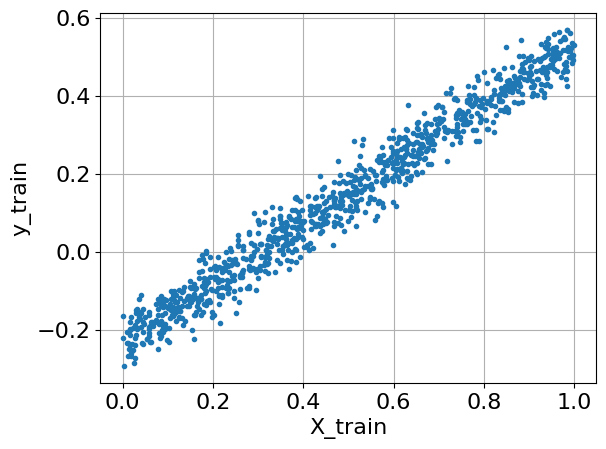

In [5]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(X_train, y_train, '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.set_ylabel('y_train')

### PyTorch `Dataset`

In [6]:
#%% Dataset to manage vector to vector data
class VectorialDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, output_data):
        super(VectorialDataset, self).__init__()
        self.input_data = torch.tensor(input_data.astype('f'))
        self.output_data = torch.tensor(output_data.astype('f'))
        
    def __len__(self):
        return self.input_data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = (self.input_data[idx, :], 
                  self.output_data[idx, :])  
        return sample 

In [7]:
training_set = VectorialDataset(input_data=X_train, output_data=y_train)

In [8]:
len(training_set)

1000

In [9]:
training_set[10:12]

(tensor([[0.9048],
         [0.3304]]),
 tensor([[0.4234],
         [0.0299]]))

Here almost useless, but think about e.g. images.

### PyTorch `DataLoader`

In [10]:
batch_size = 120
train_loader = torch.utils.data.DataLoader(training_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)

The role of `batch_size`:

In [11]:
for idx, batch in enumerate(train_loader):
    print('Batch n. %2d: input size=%s, output size=%s' % (idx+1, batch[0].shape, batch[1].shape))

Batch n.  1: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  2: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  3: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  4: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  5: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  6: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  7: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  8: input size=torch.Size([120, 1]), output size=torch.Size([120, 1])
Batch n.  9: input size=torch.Size([40, 1]), output size=torch.Size([40, 1])


In [12]:
8 * 120

960

The role of `shuffle`:

In [12]:
first_batch = []

for epoch in range(2):
    for idx, batch in enumerate(train_loader):
        if idx == 0:
            first_batch.append(batch)
        
np.c_[X_train[:batch_size], first_batch[0][0].numpy(), first_batch[1][0].numpy()]

array([[0.6707291 , 0.51725811, 0.44624507],
       [0.1360181 , 0.01655141, 0.90507191],
       [0.33822042, 0.85436124, 0.82091886],
       [0.56104074, 0.08580325, 0.12432026],
       [0.81698683, 0.09346494, 0.10811304],
       [0.88440912, 0.73014069, 0.44996488],
       [0.53790093, 0.62781453, 0.4958598 ],
       [0.30079718, 0.50601375, 0.55888754],
       [0.88659483, 0.28553778, 0.2476497 ],
       [0.92990732, 0.83685726, 0.6832751 ],
       [0.90481304, 0.82040757, 0.93909985],
       [0.33037538, 0.56928253, 0.70054489],
       [0.06748263, 0.51774096, 0.8102895 ],
       [0.20672778, 0.18624817, 0.01628437],
       [0.66234596, 0.14995423, 0.67274785],
       [0.15803027, 0.68521196, 0.10715467],
       [0.8758034 , 0.20672777, 0.12675785],
       [0.60670065, 0.95264167, 0.69179583],
       [0.98476718, 0.96766174, 0.42685151],
       [0.125635  , 0.63207287, 0.36191323],
       [0.98431155, 0.74139977, 0.29566383],
       [0.2749283 , 0.12645777, 0.58951026],
       [0.

## Models

We implement a linear model $$x \mapsto model(x):=A x + b$$ 

with $A\in \mathbb{R}^{input\_dim\times output\_dim}$, $b\in\mathbb{R}^{output\_dim}$.

In [13]:
import torch.nn as nn
import torch

#%% Linear layer
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim

        self.linear = nn.Linear(self.input_dim, self.output_dim, bias=True)

    def forward(self, x):
        out = self.linear(x)
        return out
    
    def reset(self):
        self.linear.reset_parameters()

In [14]:
model = LinearModel(input_dim, output_dim)

### Model inspection

In [15]:
print(model)

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


See [pytorch.org/docs/stable/nn.html](https://pytorch.org/docs/stable/nn.html) for many other layers.

In [16]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.8217]], requires_grad=True),
 Parameter containing:
 tensor([-0.6179], requires_grad=True)]

In [17]:
model.linear.weight

Parameter containing:
tensor([[-0.8217]], requires_grad=True)

In [19]:
model.linear.bias

Parameter containing:
tensor([-0.6179], requires_grad=True)

### The `forward` method

In [20]:
x = torch.randn(5, input_dim)
model.forward(x)

tensor([[ 0.4172],
        [-1.5129],
        [ 0.7236],
        [-1.4966],
        [-1.4098]], grad_fn=<AddmmBackward0>)

In [21]:
[model.linear.weight @ xx + model.linear.bias for xx in x]

[tensor([0.4172], grad_fn=<AddBackward0>),
 tensor([-1.5129], grad_fn=<AddBackward0>),
 tensor([0.7236], grad_fn=<AddBackward0>),
 tensor([-1.4966], grad_fn=<AddBackward0>),
 tensor([-1.4098], grad_fn=<AddBackward0>)]

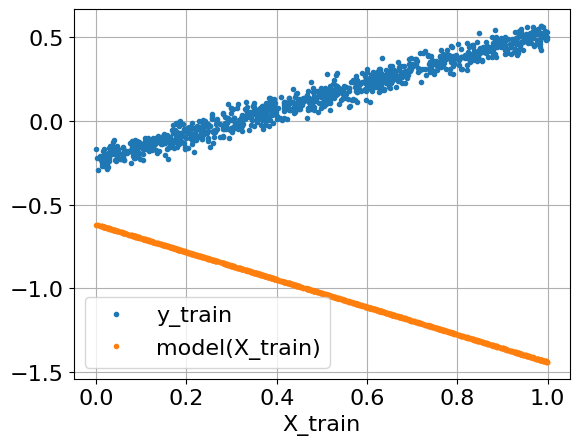

In [22]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(training_set.input_data, training_set.output_data, '.')
    ax.plot(training_set.input_data, model.forward(training_set.input_data).detach().numpy(), '.')
    ax.grid(True)
    ax.set_xlabel('X_train')
    ax.legend(['y_train', 'model(X_train)'])    

## Losses

### The MSE loss

The MSE loss is
$$
L(y, y') = \|y-y'\|_2^2
$$

In [23]:
import torch.nn as nn
loss_fun = nn.MSELoss(reduction='mean')

More at [pytorch.org/docs/stable/nn.html#loss-functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [24]:
x = torch.tensor(np.array([1, 2, 1]).astype('f'))
z = torch.tensor(np.array([0, 0, 0]).astype('f'))
loss_fun(x, z)

tensor(2.)

### Giving a score to the model (parameters) given the training set

The loss for one data pair $(x_i, y_i)$ is 
$$
L(model(x_i), y_i)
$$

The cumulative (average) loss on the training set is 
$$
L(X_{train}, y_{train}):=\frac{1}{n_{train}} \sum_{i=1}^{n_{train}} L(model(x_i), y_i)
$$

/tmp/ipykernel_9135/3716101907.py:13: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss_values[i, j] = loss_fun(model.forward(training_set.input_data),  training_set.output_data)


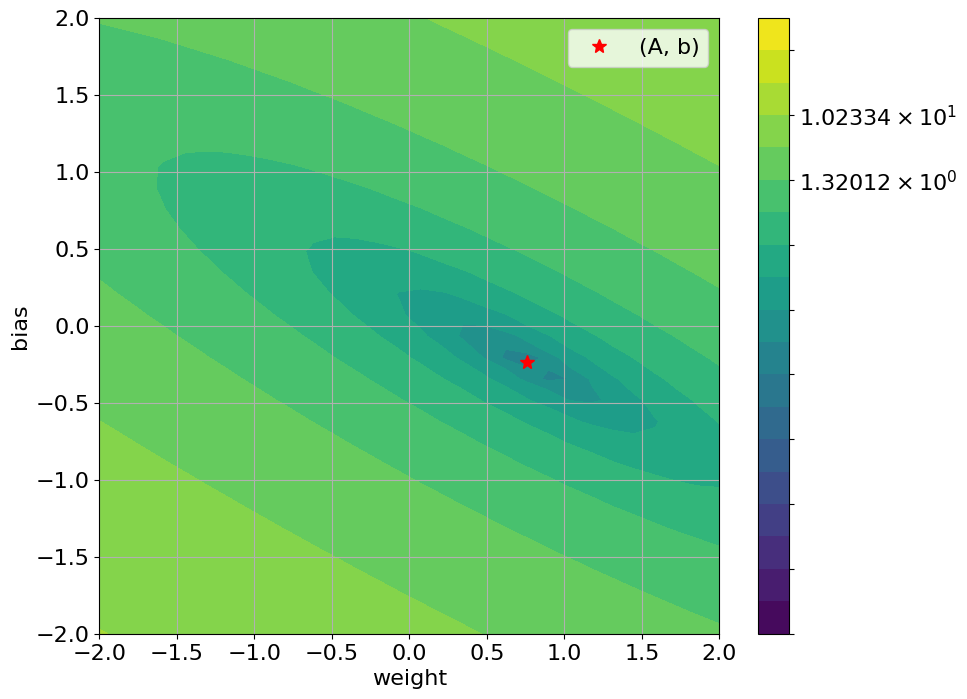

In [25]:
if input_dim == output_dim == 1:

    state_dict = model.state_dict()

    ww, bb = np.meshgrid(np.linspace(-2, 2, 30), np.linspace(-2, 2, 30))

    loss_values = 0 * ww
    for i in range(ww.shape[0]):
        for j in range(ww.shape[1]):
            state_dict['linear.weight'] = torch.tensor([[ww[i, j]]])
            state_dict['linear.bias'] = torch.tensor([bb[i, j]])
            model.load_state_dict(state_dict)
            loss_values[i, j] = loss_fun(model.forward(training_set.input_data),  training_set.output_data)

    fig = plt.figure(figsize=(10, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    c=ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    plt.colorbar(c)
    ax.plot(A[0], b, 'r*', markersize=10)
    ax.set_ylabel('bias')
    ax.set_xlabel('weight')
    ax.legend(['(A, b)'])
    
    ax.grid(True)    

## Optimization

Goal: minimize the loss given the data:
$$
\min\limits_{par \in model} L(X_{train}, y_{train})
=\min\limits_{par \in model} \frac{1}{n_{train}} \sum_{i=1}^{n_{train}} L(x_i, model(x_i))
$$

In this case $par =\{A, b\}$.

Iterative gradient based optimization:
\begin{align*}
par^{(0)} &= par_0\\
par^{(k+1)} &=  par^{(k)} - \eta^{(k)} \nabla_{par} L(X_{train}, y_{train})
\end{align*}    
with learning rate $\eta^{(k)}$.

### Gradients

The model is 
$$
model(x) = A x + b
$$

With $input\_dim = output\_dim = 1$ we have $A:=a\in\mathbb{R},\ b\in\mathbb{R}$. 

For a data pair $(x, y)$ the loss is
\begin{align*}
L(x, y) 
&= \|model(x)-y\|_2^2\\ 
&= (model(x)-y)^2\\
&= (a x + b - y)^2\\
&= a^2 x^2 + 2 a b x - 2 a xy + b^2 -2 b y + y^2.
\end{align*}

We can compute
\begin{align*}
\nabla_a L(x, y) 
&= 2 a x^2 + 2 b x - 2 xy
=2 x (a x + b - y)\\
\nabla_b L(x, y)
&= 2 a x + 2 b - 2 y
= 2 (ax + b - y).
\end{align*}


In [26]:
x = torch.randn(1, input_dim)
y =  torch.randn(1, output_dim)

model.zero_grad()
loss = loss_fun(model.forward(x),  y)
loss.backward()

In [27]:
if input_dim == output_dim == 1:
    print(model.linear.weight.grad)
    print(2 * x * (model.linear.weight * x + model.linear.bias - y))
    
    print(model.linear.bias.grad)
    print(2 * (model.linear.weight * x + model.linear.bias - y))

tensor([[-0.1449]])
tensor([[-0.1449]], grad_fn=<MulBackward0>)
tensor([-1.1845])
tensor([[-1.1845]], grad_fn=<MulBackward0>)


### Handmade optimization

In [32]:
if input_dim == output_dim == 1:

    num_iter = 200
    lr = 0.2

    train_hist = {}
    train_hist['weight'] = []
    train_hist['bias'] = []

    model.reset()
    state_dict = model.state_dict()

    for _ in range(num_iter):

        model.zero_grad()
        loss = loss_fun(model.forward(training_set.input_data), training_set.output_data)
        loss.backward()

        w = model.linear.weight.item()
        b = model.linear.bias.item()

        dw = model.linear.weight.grad.item()
        db = model.linear.bias.grad.item()

        state_dict['linear.weight'] += torch.tensor([-lr * dw])
        state_dict['linear.bias'] += torch.tensor([-lr * db])
        model.load_state_dict(state_dict)

        train_hist['weight'].append(w)
        train_hist['bias'].append(b)

    for label in train_hist:
        train_hist[label] = np.array(train_hist[label])

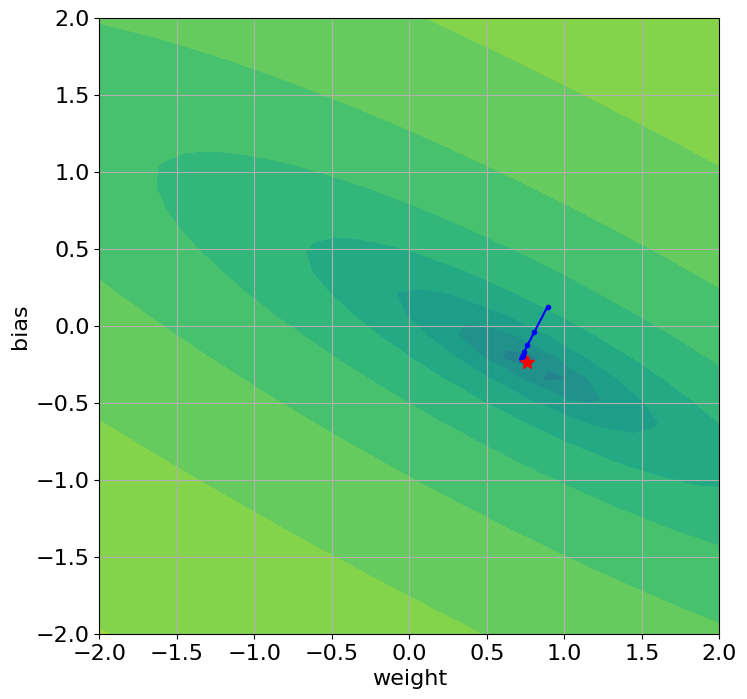

In [33]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(8, 8))
    fig.clf()
    ax = fig.gca()
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    ax.grid(True)
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2) 
    
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)

    #ax.legend(['optim', '(A, b)'])

### Stochastic GD

* Avoid loading the full training set
* Avoid evaluating the model on the full training set

At every step, compute the loss on a batch of data $(X^{(k)}, y^{(k)})\sim (X_{train}, y_{train})$: 

\begin{align*}
L(X^{(k)}, y^{(k)}) := \sum_{(x, y) \in (X^{(k)}, y^{(k)})} L(x, model(x)).
\end{align*}    

and then update with this approximated gradient:
\begin{align*}
par^{(k+1)} &=  par^{(k)} - \eta^{(k)} \nabla_{par} L(X^{(k)}, y^{(k)}). 
\end{align*}    

### PyTorch `optim`

In [34]:
lr = 0.1
weight_decay = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

More at [pytorch.org/docs/stable/optim.html](https://pytorch.org/docs/stable/optim.html).

In [35]:
n_epochs = 100

In [36]:
train_hist = {}
train_hist['loss'] = []

if input_dim == output_dim == 1:
    train_hist['weight'] = []
    train_hist['bias'] = []

# Initialize training
model.reset()
model.train()

for epoch in range(n_epochs):
    for idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        loss = loss_fun(model.forward(batch[0]),  batch[1])
        loss.backward()
        optimizer.step()

        train_hist['loss'].append(loss.item())
        if input_dim == output_dim == 1:
            train_hist['weight'].append(model.linear.weight.item())
            train_hist['bias'].append(model.linear.bias.item())
        
        print('[Epoch %4d/%4d] [Batch %4d/%4d] Loss: % 2.2e' % (epoch + 1, n_epochs, 
                                                                idx + 1, len(train_loader), 
                                                                loss.item()))
        
model.eval()

[Epoch    1/ 100] [Batch    1/   9] Loss:  9.26e-01
[Epoch    1/ 100] [Batch    2/   9] Loss:  6.49e-01
[Epoch    1/ 100] [Batch    3/   9] Loss:  4.27e-01
[Epoch    1/ 100] [Batch    4/   9] Loss:  2.92e-01
[Epoch    1/ 100] [Batch    5/   9] Loss:  1.72e-01
[Epoch    1/ 100] [Batch    6/   9] Loss:  8.22e-02
[Epoch    1/ 100] [Batch    7/   9] Loss:  4.94e-02
[Epoch    1/ 100] [Batch    8/   9] Loss:  3.75e-02
[Epoch    1/ 100] [Batch    9/   9] Loss:  6.26e-02
[Epoch    2/ 100] [Batch    1/   9] Loss:  8.55e-02
[Epoch    2/ 100] [Batch    2/   9] Loss:  1.10e-01
[Epoch    2/ 100] [Batch    3/   9] Loss:  1.41e-01
[Epoch    2/ 100] [Batch    4/   9] Loss:  1.47e-01
[Epoch    2/ 100] [Batch    5/   9] Loss:  1.41e-01
[Epoch    2/ 100] [Batch    6/   9] Loss:  1.46e-01
[Epoch    2/ 100] [Batch    7/   9] Loss:  1.30e-01
[Epoch    2/ 100] [Batch    8/   9] Loss:  1.06e-01
[Epoch    2/ 100] [Batch    9/   9] Loss:  8.87e-02
[Epoch    3/ 100] [Batch    1/   9] Loss:  6.22e-02
[Epoch    3/

LinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)

In [37]:
if input_dim == output_dim == 1:
    n_test = 500
    X_test = np.random.rand(n_test, input_dim)
    y_pred = []

    state_dict = model.state_dict()

    for idx in range(len(train_hist['weight'])):
        state_dict['linear.weight'] = torch.tensor([[train_hist['weight'][idx]]])
        state_dict['linear.bias'] = torch.tensor([train_hist['bias'][idx]])
        model.load_state_dict(state_dict)

        y_pred.append(model.forward(torch.tensor(X_test.astype('f'))).detach().numpy())    

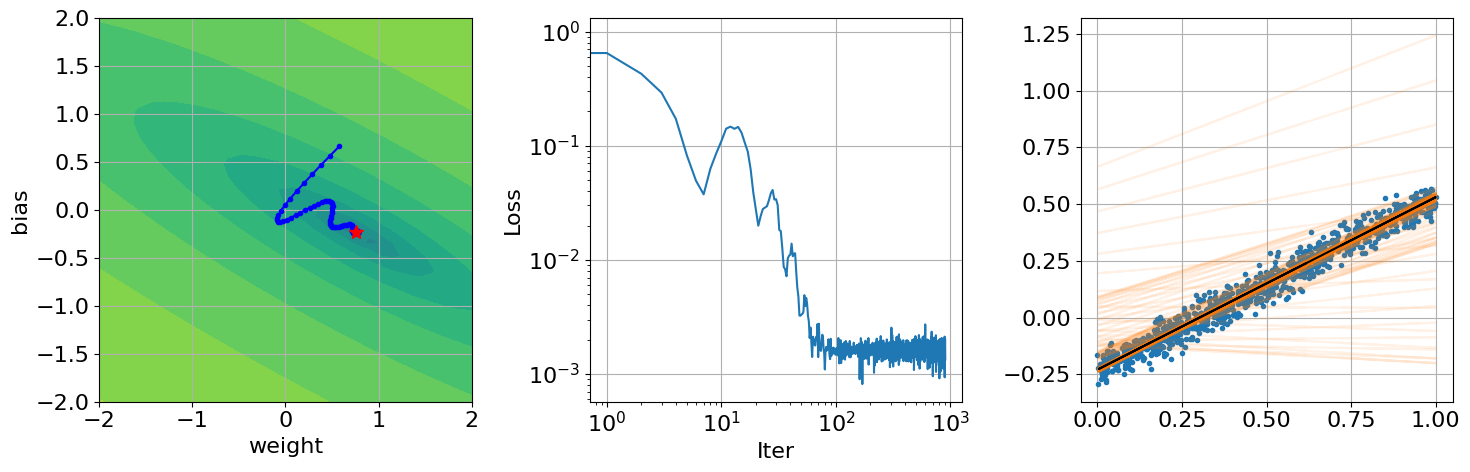

In [38]:
if input_dim == output_dim == 1:
    fig = plt.figure(figsize=(15, 5))
    fig.clf()
    
    ax = fig.add_subplot(1, 3, 1)
    levels = np.logspace(np.log(np.min(loss_values)), np.log(np.max(loss_values)), 20)
    ax.contourf(ww, bb, loss_values, levels=levels, norm=colors.LogNorm())
    ax.plot(train_hist['weight'], train_hist['bias'], '.-b')
    ax.plot(A[0], b, 'r*', markersize=10)
    ax.set_xlabel('weight')
    ax.set_ylabel('bias')
    #ax.legend(['optim', '(A, b)'])
    ax.grid(True)
    ax.set_xlim(-2, 2) 
    ax.set_ylim(-2, 2) 
    
    ax = fig.add_subplot(1, 3, 2)
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)
    
    ax = fig.add_subplot(1, 3, 3)
    ax.plot(X_train, y_train, '.')
    a=ax.plot(X_test, y_pred[0], '-', alpha=0.1)
    for y in y_pred[1:]:
        ax.plot(X_test, y, '-', alpha=0.1, color=a[0].get_color())
    ax.plot(X_test, y_pred[-1], 'k')
    ax.grid(True)   

    fig.tight_layout()

else:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.loglog(np.abs(train_hist['loss']))
    ax.set_xlabel('Iter')
    ax.set_ylabel('Loss')
    ax.grid(True)